In [17]:
from skimage import io

# Load the tif file
image_stack = io.imread('images/xAM_data_processing_Sudarsh/mT89_re2_DMEM_2025-04-18@20-27-57.tif')

image_stack = image_stack[:, 300:700, :]

In [18]:
image_stack.shape

(1073, 400, 641)

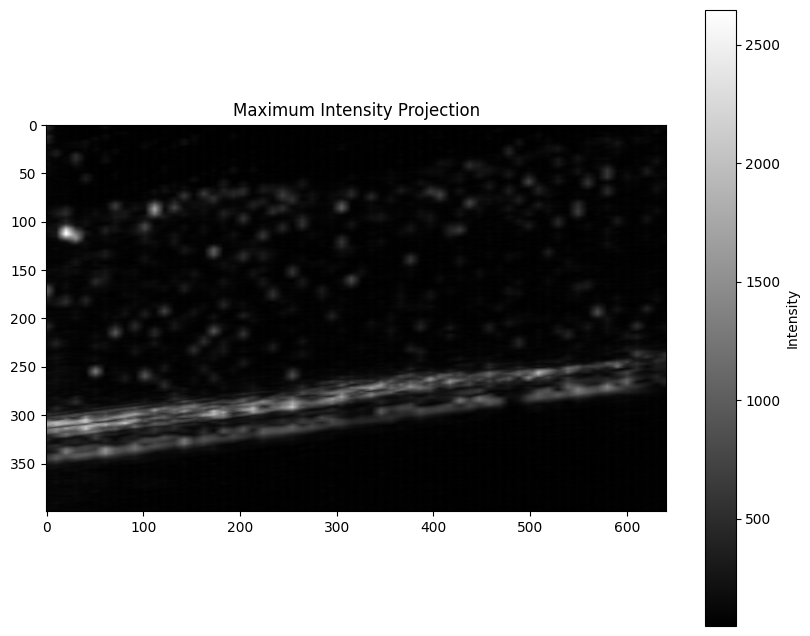

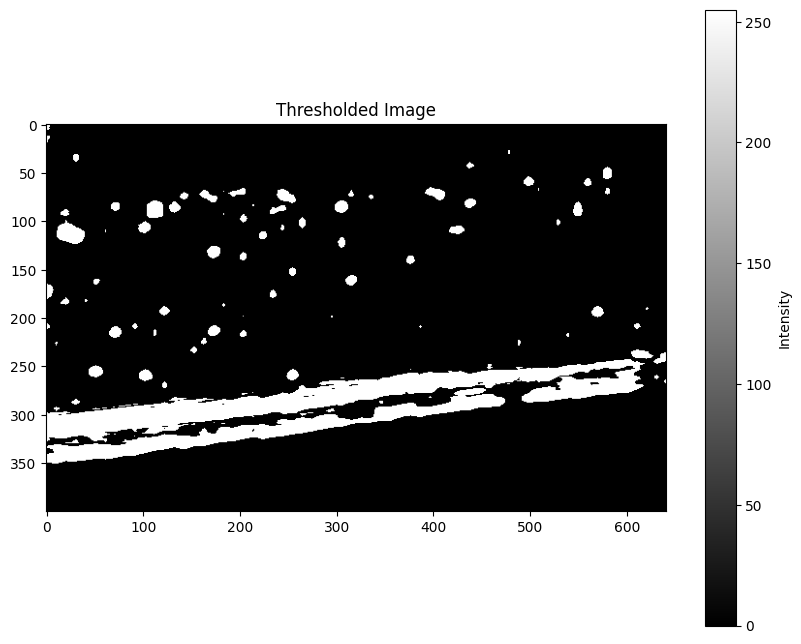

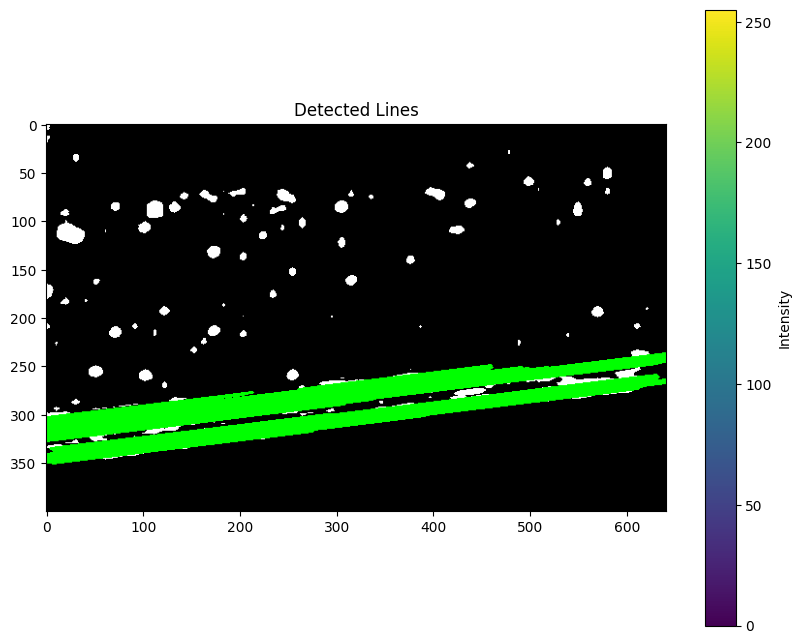

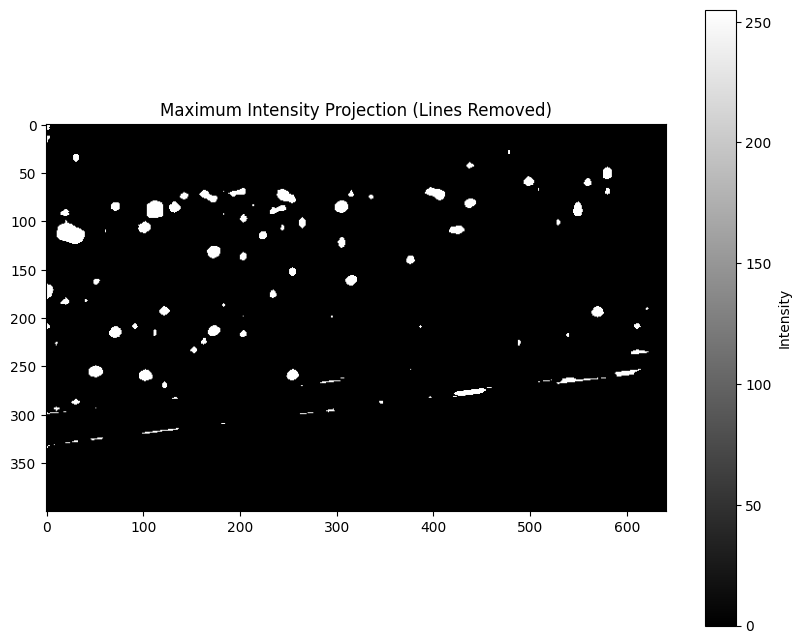

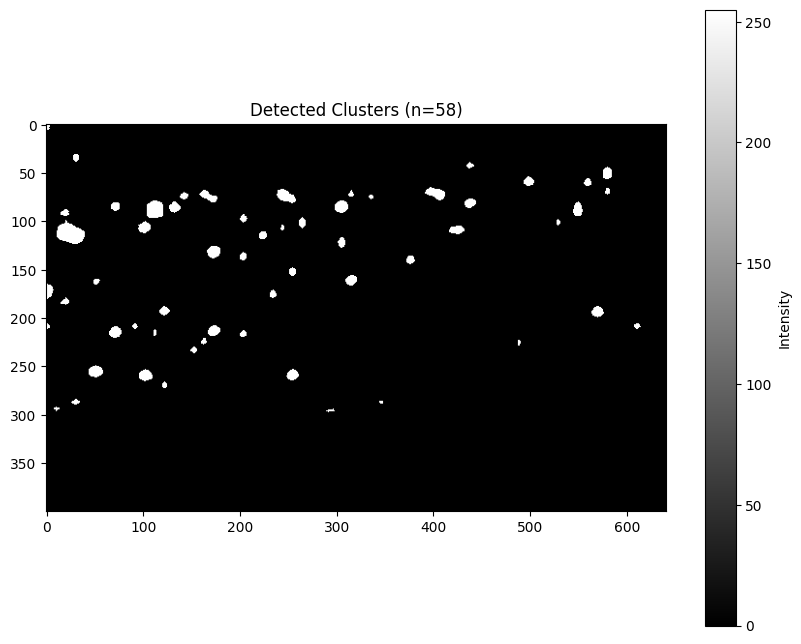

Total number of clusters detected: 58
Cluster 1:
  Area: 24 pixels
  Bounding box: x=0, y=0, width=5, height=7
  Centroid: (1.4, 2.4)
  Eccentricity: 0.855
Cluster 4:
  Area: 40 pixels
  Bounding box: x=28, y=31, width=6, height=8
  Centroid: (30.5, 34.2)
  Eccentricity: 0.646
Cluster 5:
  Area: 33 pixels
  Bounding box: x=434, y=39, width=8, height=7
  Centroid: (437.3, 42.3)
  Eccentricity: 0.567
Cluster 6:
  Area: 97 pixels
  Bounding box: x=575, y=44, width=9, height=13
  Centroid: (578.9, 50.4)
  Eccentricity: 0.486
Cluster 7:
  Area: 78 pixels
  Bounding box: x=493, y=54, width=11, height=10
  Centroid: (497.9, 58.9)
  Eccentricity: 0.527
Cluster 8:
  Area: 48 pixels
  Bounding box: x=555, y=56, width=8, height=8
  Centroid: (558.7, 59.8)
  Eccentricity: 0.406
Cluster 9:
  Area: 178 pixels
  Bounding box: x=391, y=65, width=21, height=14
  Centroid: (402.0, 71.2)
  Eccentricity: 0.876
Cluster 11:
  Area: 187 pixels
  Bounding box: x=238, y=67, width=20, height=15
  Centroid: (247

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

max_image = image_stack.max(axis = 0)
# Recompute max image after cropping
max_image = image_stack.max(axis=0)


# Plot max image
plt.figure(figsize=(10,8))
plt.imshow(max_image, cmap='gray')
plt.colorbar(label='Intensity')
plt.title('Maximum Intensity Projection')
plt.show()

# Create binary thresholded image
threshold = np.percentile(max_image, 90)  # Use same threshold as before
thresholded_image = (max_image > threshold).astype(np.uint8) * 255

# Display the thresholded image
plt.figure(figsize=(10,8))
plt.imshow(thresholded_image, cmap='gray')
plt.colorbar(label='Intensity')
plt.title('Thresholded Image')
plt.show()

binary_image = (thresholded_image).astype(np.uint8) * 255

# Apply Hough transform
lines = cv2.HoughLinesP(binary_image, 
                        rho=1,
                        theta=np.pi/180,
                        threshold=40,
                        minLineLength=150,
                        maxLineGap=40)

# Create a copy of max_image for visualization
line_image = cv2.cvtColor(thresholded_image.astype(np.uint8), cv2.COLOR_GRAY2BGR)

# Draw detected lines
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the result
plt.figure(figsize=(10,8))
plt.imshow(line_image)
plt.title('Detected Lines')
plt.colorbar(label='Intensity')
plt.show()

# Create a mask for the lines
line_mask = np.zeros_like(max_image)
for line in lines:
    x1, y1, x2, y2 = line[0]
    # Draw thicker lines (width=5) on the mask
    cv2.line(line_mask, (x1, y1), (x2, y2), 1, 5)

thresholded_image[line_mask > 0] = 0

plt.figure(figsize=(10,8))
plt.imshow(thresholded_image, cmap='gray')
plt.colorbar(label='Intensity')
plt.title('Maximum Intensity Projection (Lines Removed)')
plt.show()

# Find connected components (clusters) in the thresholded image
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresholded_image, connectivity=8)

# Calculate eccentricity for each component
eccentricities = []
for i in range(1, num_labels):
    # Get component mask
    component = (labels == i).astype(np.uint8)
    # Find contours
    contours, _ = cv2.findContours(component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        # Fit ellipse to contour
        if len(contours[0]) >= 5:  # Need at least 5 points to fit ellipse
            ellipse = cv2.fitEllipse(contours[0])
            major_axis = max(ellipse[1])
            minor_axis = min(ellipse[1])
            eccentricity = np.sqrt(1 - (minor_axis/major_axis)**2)
        else:
            eccentricity = 0
    else:
        eccentricity = 0
    eccentricities.append(eccentricity)

# Filter clusters based on size and eccentricity
min_cluster_size = 10  # Reduced size threshold
max_eccentricity = 0.95  # Filter out very elongated shapes
valid_clusters = np.logical_and(
    stats[1:, cv2.CC_STAT_AREA] > min_cluster_size,
    np.array(eccentricities) < max_eccentricity
)

# Create a visualization of the clusters
cluster_image = np.zeros_like(thresholded_image)
colors = np.random.randint(50, 255, size=(len(stats), 3), dtype=np.uint8)
colors[0] = [0, 0, 0]  # Background is black

for i in range(1, num_labels):
    if valid_clusters[i-1]:
        cluster_image[labels == i] = 255

# Display the clusters
plt.figure(figsize=(10,8))
plt.imshow(cluster_image, cmap='gray')
plt.colorbar(label='Intensity')
plt.title(f'Detected Clusters (n={np.sum(valid_clusters)})')
plt.show()

# Print cluster statistics
print(f"Total number of clusters detected: {np.sum(valid_clusters)}")
for i in range(1, num_labels):
    if valid_clusters[i-1]:
        area = stats[i, cv2.CC_STAT_AREA]
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        print(f"Cluster {i}:")
        print(f"  Area: {area} pixels")
        print(f"  Bounding box: x={x}, y={y}, width={w}, height={h}")
        print(f"  Centroid: ({centroids[i][0]:.1f}, {centroids[i][1]:.1f})")
        print(f"  Eccentricity: {eccentricities[i-1]:.3f}")





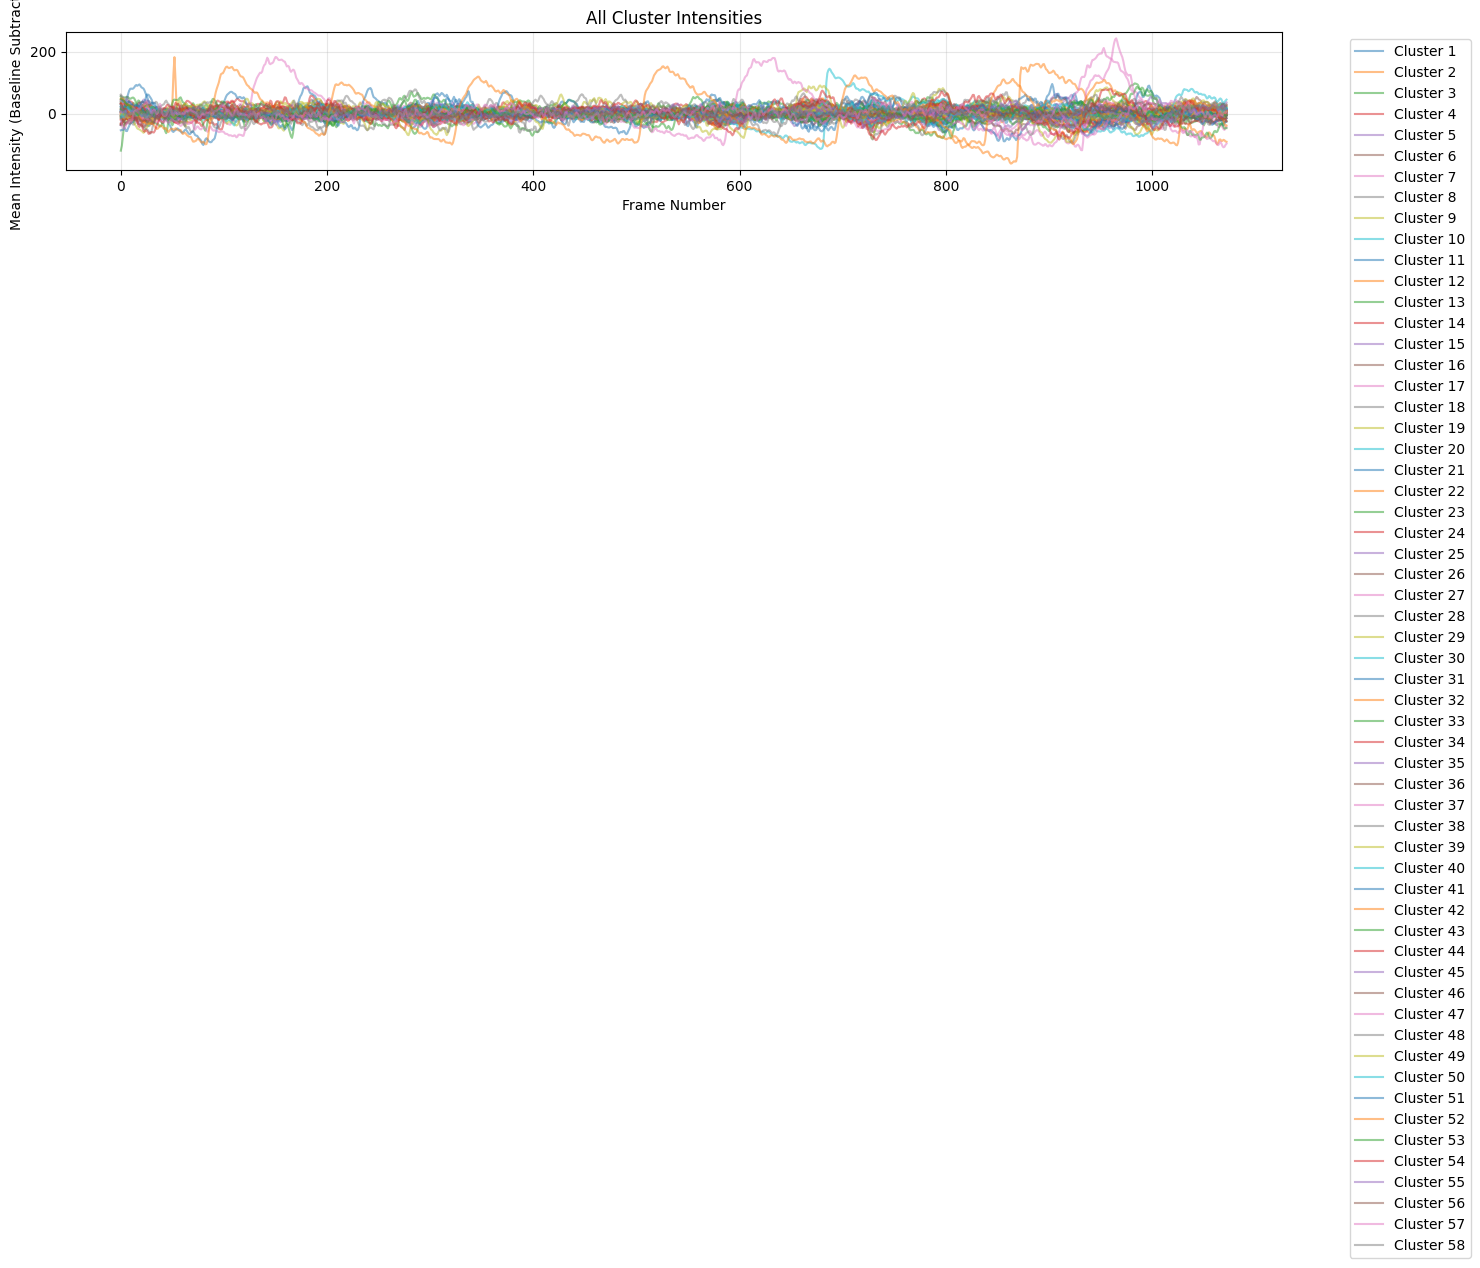

In [ ]:
from scipy.ndimage import gaussian_filter1d
import numpy as np
from scipy.signal import savgol_filter

# Apply Gaussian smoothing along time axis
smoothed_stack = gaussian_filter1d(image_stack, sigma=1, axis=0)

# Count number of valid clusters
n_valid = np.sum(valid_clusters)

# Initialize array to store all cluster intensities
cell_intensities = np.zeros((n_valid, len(smoothed_stack)))

# Counter for valid clusters
cluster_idx = 0

# For each valid cluster, calculate its mean intensity over time
for i in range(1, num_labels):
    if valid_clusters[i-1]:
        # Create a mask for this cluster
        cluster_mask = (labels == i)
        
        # Calculate mean intensity over time for this cluster
        for t in range(len(smoothed_stack)):
            mean_intensity = np.mean(smoothed_stack[t][cluster_mask])
            cell_intensities[cluster_idx, t] = mean_intensity
            
        # Calculate baseline using a very wide window moving average
        window_size = len(smoothed_stack) // 4  # Use 1/4 of signal length
        if window_size % 2 == 0:  # Make window size odd
            window_size += 1
        baseline = savgol_filter(cell_intensities[cluster_idx], window_size, 1)
        
        # Subtract baseline
        cell_intensities[cluster_idx] -= baseline
        
        cluster_idx += 1

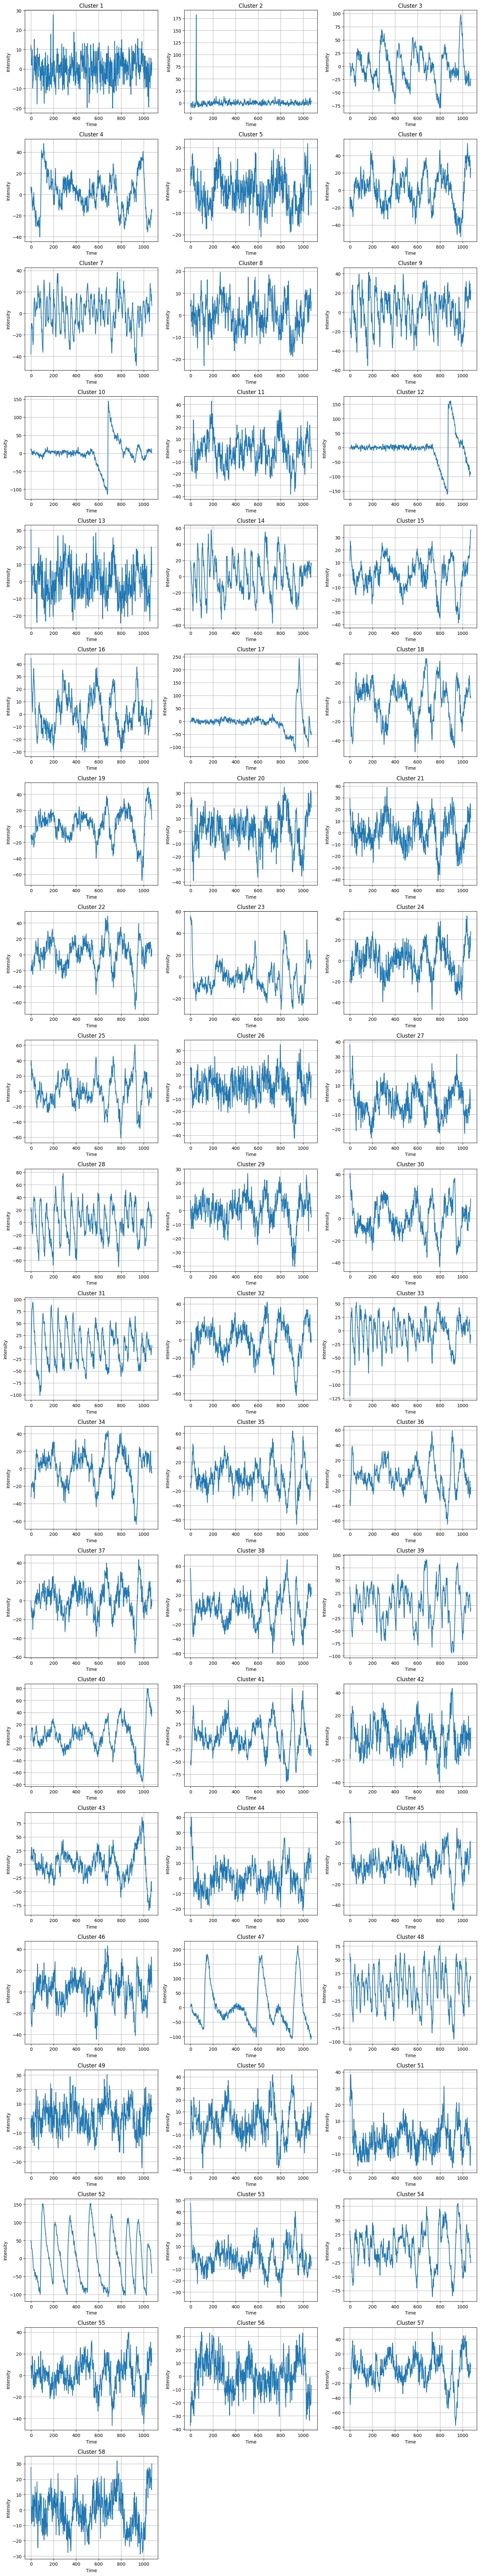

In [26]:
# Create a figure with subplots for each cluster
n_rows = int(np.ceil(n_valid / 3))  # 3 columns
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
axes = axes.flatten()

# Plot each cluster's intensity over time
for i in range(n_valid):
    axes[i].plot(cell_intensities[i], label=f'Cluster {i+1}')
    axes[i].set_title(f'Cluster {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Intensity')
    axes[i].grid(True)

# Hide empty subplots
for i in range(n_valid, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

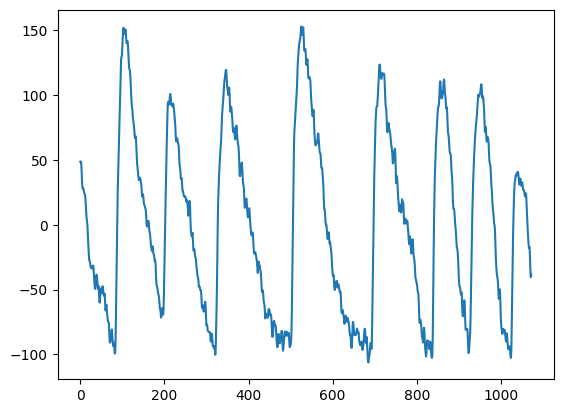

In [27]:
cluster = cell_intensities[51]

plt.plot(cluster)

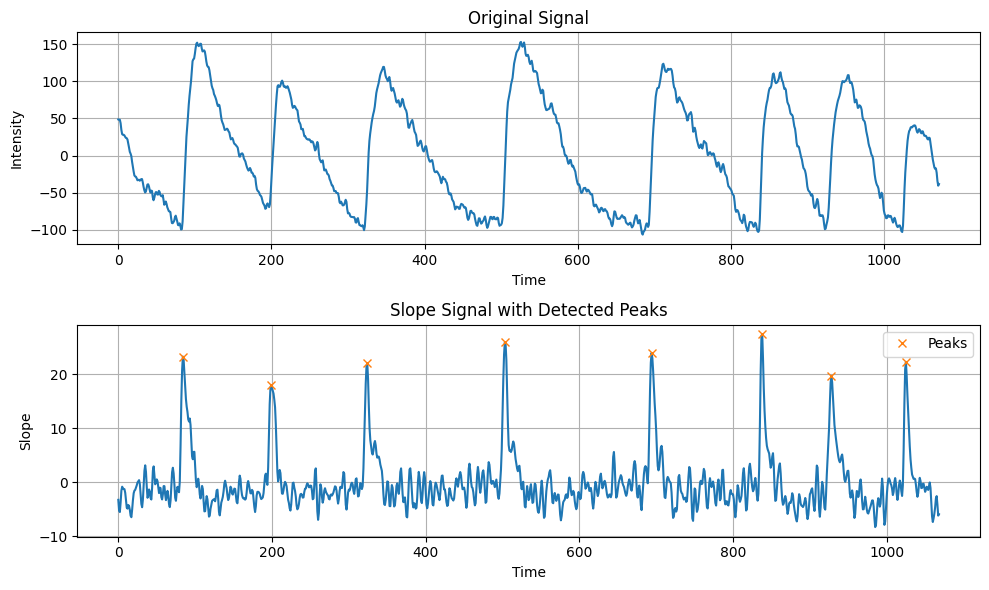

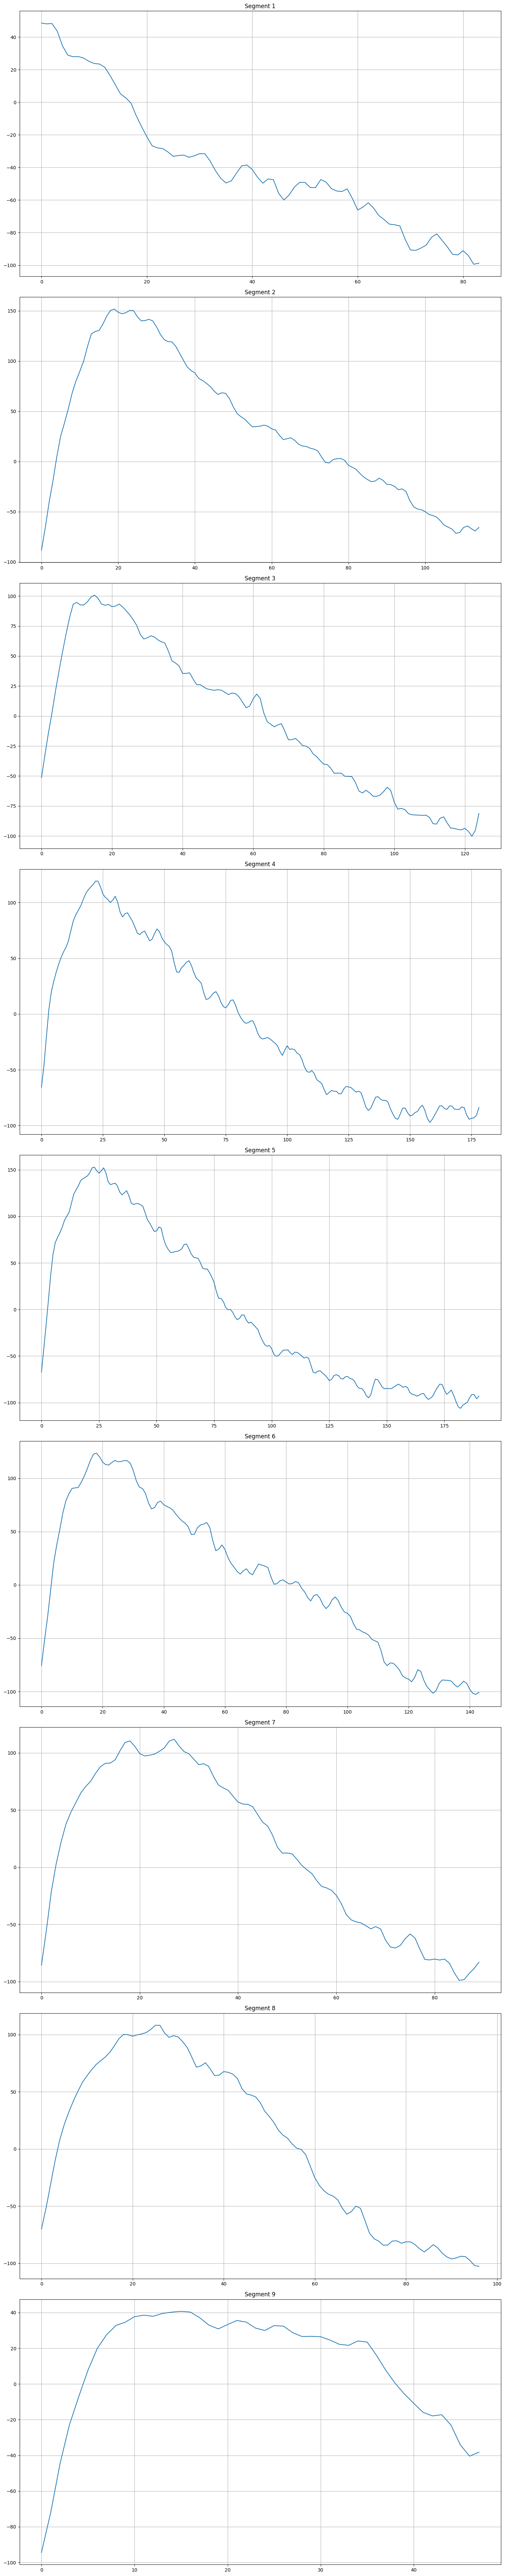

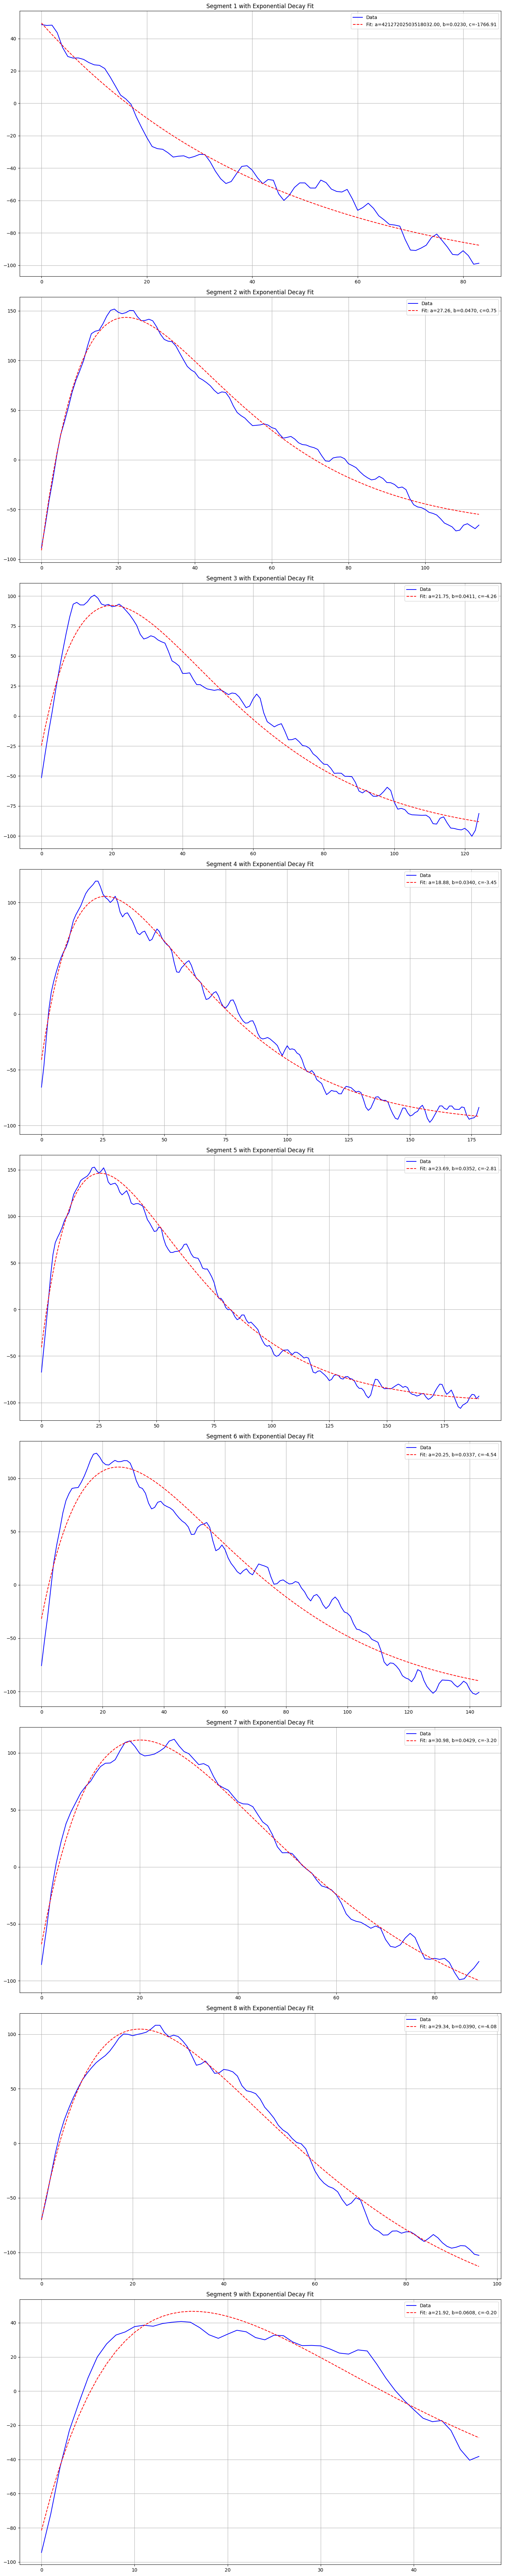

In [45]:
from scipy.signal import find_peaks

# Calculate slope using a moving window of 5 points
slopes = np.zeros(len(cluster)-4)
for i in range(len(cluster)-4):
    window = cluster[i:i+5]
    slope = np.polyfit(np.arange(5), window, 1)[0]
    slopes[i] = slope

# Find peaks in the slope
peaks, _ = find_peaks(slopes, prominence=20)

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Plot original signal and peaks
ax1.plot(cluster)
ax1.set_title('Original Signal')
ax1.set_xlabel('Time')
ax1.set_ylabel('Intensity')
ax1.grid(True)

# Plot slopes and detected peaks
ax2.plot(np.arange(len(slopes)), slopes)
ax2.plot(peaks, slopes[peaks], "x", label='Peaks')
ax2.set_title('Slope Signal with Detected Peaks')
ax2.set_xlabel('Time')
ax2.set_ylabel('Slope')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Plot partitioned segments
plt.figure(figsize=(15, 76))
peak_indices = np.concatenate(([0], peaks, [len(cluster)]))

for i in range(len(peak_indices)-1):
    start = peak_indices[i]
    end = peak_indices[i+1]
    
    plt.subplot(len(peak_indices)-1, 1, i+1)
    plt.plot(cluster[start:end])
    plt.title(f'Segment {i+1}')
    plt.grid(True)

plt.tight_layout()
plt.show()

from scipy.optimize import curve_fit

def exp_decay_func(x, a, b, c, d):
    """Function to fit: a*(x-c)*exp(-b*(x-c)) + d"""
    # Clip extremely large values to prevent overflow
    exp_term = np.clip(-b*(x-c), -100, 100)  # Limit the exponent range
    return a * (x-c) * np.exp(exp_term) + d

# Fit curves to each segment and plot results
plt.figure(figsize=(15, 76))
peak_indices = np.concatenate(([0], peaks, [len(cluster)]))
fit_params = []

for i in range(len(peak_indices)-1):
    start = peak_indices[i]
    end = peak_indices[i+1]
    segment = cluster[start:end]
    x = np.arange(len(segment))
    
    # Initial parameter guesses - adjusted for better stability
    p0 = [0.1, 0.001, 0, np.mean(segment)]  # Smaller initial values and offset guess
    
    # Add bounds to prevent extreme parameter values
    bounds = ([-np.inf, 0, -np.inf, -np.inf], [np.inf, 1, np.inf, np.inf])
    
    try:
        # Fit the curve with bounds
        popt, _ = curve_fit(exp_decay_func, x, segment, p0=p0, maxfev=10000, bounds=bounds)
        fit_params.append(popt)
        
        # Plot original data and fitted curve
        plt.subplot(len(peak_indices)-1, 1, i+1)
        plt.plot(x, segment, 'b-', label='Data')
        plt.plot(x, exp_decay_func(x, *popt), 'r--', 
                label=f'Fit: a={popt[0]:.2f}, b={popt[1]:.4f}, c={popt[2]:.2f}')
        plt.title(f'Segment {i+1} with Exponential Decay Fit')
        plt.grid(True)
        plt.legend()
        
    except RuntimeError:
        print(f"Could not fit segment {i+1}")
        plt.subplot(len(peak_indices)-1, 1, i+1)
        plt.plot(x, segment, 'b-', label='Data')
        plt.title(f'Segment {i+1} (Fitting Failed)')
        plt.grid(True)
        plt.legend()

plt.tight_layout()
plt.show()



/var/folders/3n/sjbgw9357l188k3xlvvxhwyc0000gn/T/ipykernel_71307/2736366315.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_decay_func, x, segment, p0=p0, maxfev=10000, bounds=bounds)


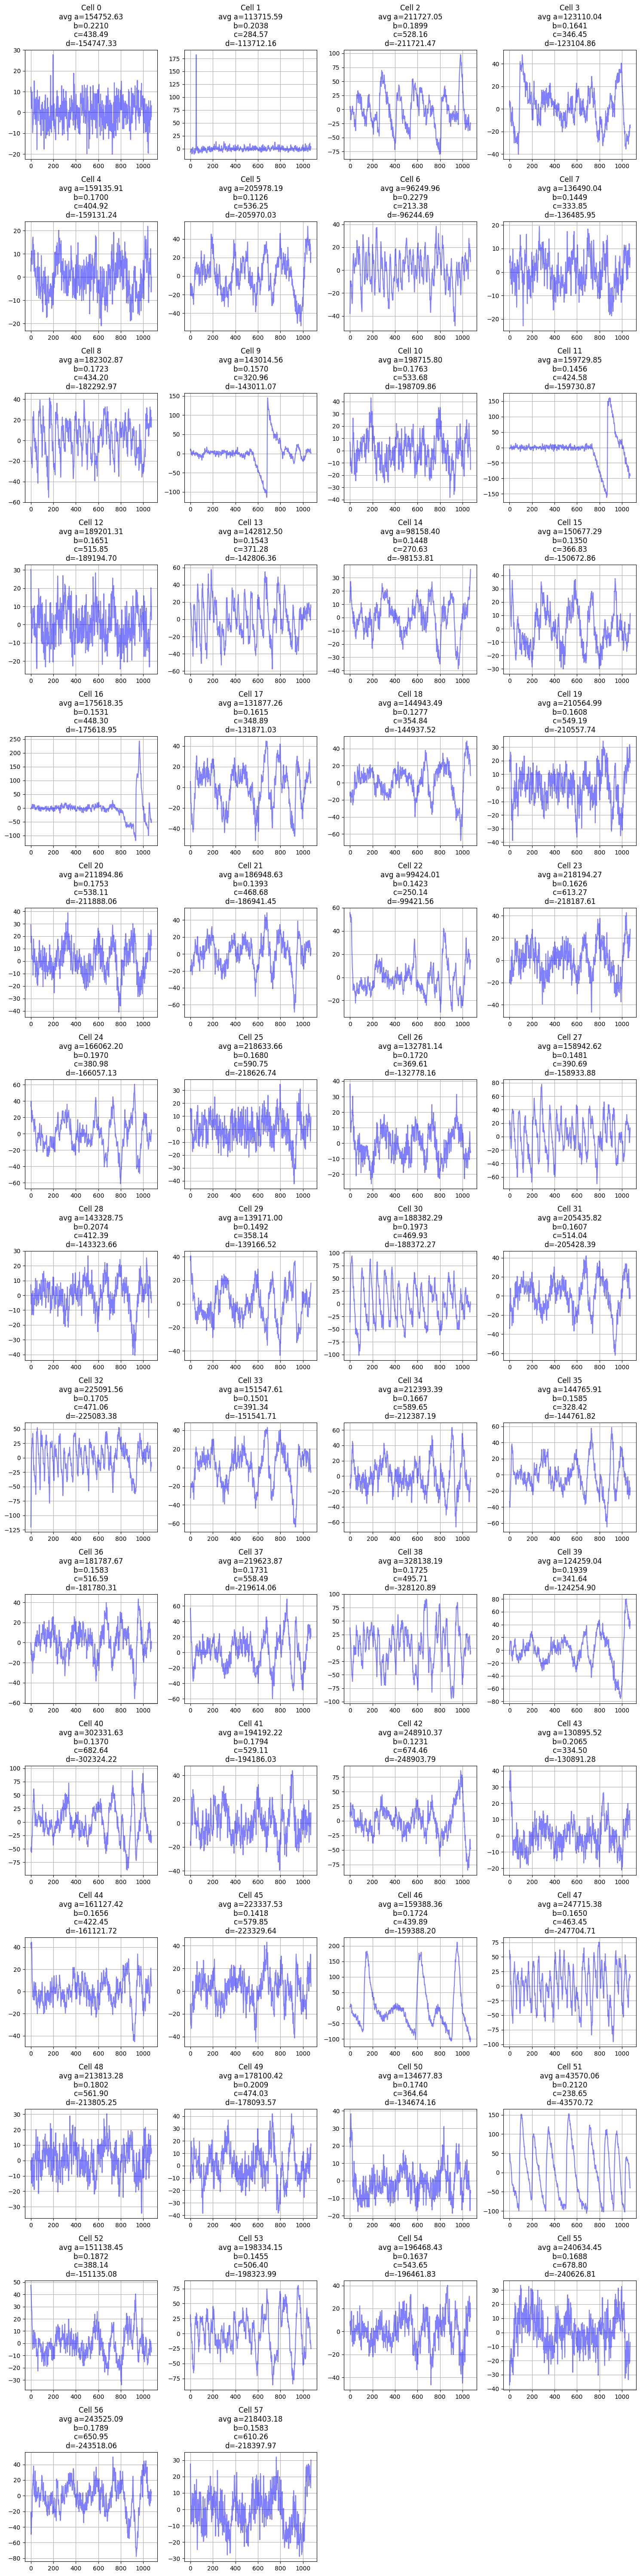

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def process_cell(cell_data):
    # Find peaks using same threshold
    peaks, _ = find_peaks(cell_data, prominence=20)
    
    if len(peaks) == 0:
        return None, None  # Return None for cells with no peaks
        
    # Process segments between peaks
    peak_indices = np.concatenate(([0], peaks, [len(cell_data)]))
    cell_fit_params = []
    
    for i in range(len(peak_indices)-1):
        start = peak_indices[i]
        end = peak_indices[i+1]
        segment = cell_data[start:end]
        x = np.arange(len(segment))
        
        p0 = [0.1, 0.001, 0, np.mean(segment)]
        bounds = ([-np.inf, 0, -np.inf, -np.inf], [np.inf, 1, np.inf, np.inf])
        
        try:
            popt, _ = curve_fit(exp_decay_func, x, segment, p0=p0, maxfev=10000, bounds=bounds)
            cell_fit_params.append(popt)
        except RuntimeError:
            continue
            
    if len(cell_fit_params) == 0:
        return None, None
        
    return cell_data, np.mean(cell_fit_params, axis=0)

# Process all cells sequentially
results = []
for cell_data in cell_intensities:
    results.append(process_cell(cell_data))

# Plot results
n_cells = len(cell_intensities)
n_cols = 4
n_rows = (n_cells + n_cols - 1) // n_cols
plt.figure(figsize=(15, 4*n_rows))

for cell_idx, (cell_data, avg_params) in enumerate(results):
    if cell_data is None:
        continue
        
    plt.subplot(n_rows, n_cols, cell_idx + 1)
    plt.plot(cell_data, 'b-', label='Data', alpha=0.5)
    
    if avg_params is not None:
        param_str = f'avg a={avg_params[0]:.2f}\nb={avg_params[1]:.4f}\nc={avg_params[2]:.2f}\nd={avg_params[3]:.2f}'
        plt.title(f'Cell {cell_idx}\n{param_str}')
    else:
        plt.title(f'Cell {cell_idx}\n(no peaks)')
    
    plt.grid(True)
    
plt.tight_layout()
plt.show()
